## Cell 1: Setup and Installations

In [1]:
# Install necessary libraries
!pip install torch pandas scikit-learn datasets huggingface_hub torchmetrics tqdm -q

# --- 1. Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import metrics for BINARY classification
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.6 MB/s eta 0:00:00


## Cell 2: Load and Explore the CIFAKE Dataset

In [2]:
# --- Cell 2 (Corrected): Load and Explore the SuSy Dataset ---

# Load the dataset, forcing a re-download to ensure we get the correct one
print("Loading the SuSy dataset...")
dataset = load_dataset("HPAI-BSC/SuSy-Dataset", name="susy_dataset", download_mode="force_redownload")

# Convert to pandas DataFrames for easier exploration
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()
print("Dataset loaded successfully.")

# --- Exploratory Data Analysis (EDA) ---
print("\n--- First 5 Rows ---")
print(train_df.head())

print("\n--- Data Info ---")
train_df.info()

# This will now work because the correct dataset has a 'signal' column
print("\n--- Class Distribution (0=Background, 1=Signal) ---")
print(train_df['signal'].value_counts())

Loading the SuSy dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train.zip:   0%|          | 0.00/15.2G [00:00<?, ?B/s]

data/val.zip:   0%|          | 0.00/4.73G [00:00<?, ?B/s]

data/test.zip:   0%|          | 0.00/6.02G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully.

--- First 5 Rows ---
                                               image  label
0  {'bytes': None, 'path': 'zip://train/coco/0000...      0
1  {'bytes': None, 'path': 'zip://train/coco/0000...      0
2  {'bytes': None, 'path': 'zip://train/coco/0000...      0
3  {'bytes': None, 'path': 'zip://train/coco/0000...      0
4  {'bytes': None, 'path': 'zip://train/coco/0000...      0

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14451 entries, 0 to 14450
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   14451 non-null  object
 1   label   14451 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 225.9+ KB

--- Class Distribution (0=Background, 1=Signal) ---


KeyError: 'signal'

In [4]:
# Display the first few rows of the training data
print("\n--- First 5 Rows ---")
print(train_df.head())

# Get a summary of the data types and non-null values
print("\n--- Data Info ---")
train_df.info()

# Get statistical summary of the features
print("\n--- Statistical Summary ---")
print(train_df.describe())

# CORRECTED: Use the correct column name 'label'
print("\n--- Class Distribution (Target: label) ---")
print(train_df['label'].value_counts())


--- First 5 Rows ---
                                               image  label
0  {'bytes': None, 'path': 'zip://train/coco/0000...      0
1  {'bytes': None, 'path': 'zip://train/coco/0000...      0
2  {'bytes': None, 'path': 'zip://train/coco/0000...      0
3  {'bytes': None, 'path': 'zip://train/coco/0000...      0
4  {'bytes': None, 'path': 'zip://train/coco/0000...      0

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14451 entries, 0 to 14450
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   14451 non-null  object
 1   label   14451 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 225.9+ KB

--- Statistical Summary ---
              label
count  14451.000000
mean       2.640855
std        1.790788
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000

--- Class Distribution (Target: label) ---
label
0    2967
2    2967
5    2967
4    2

## Cell 3: Data Preprocessing for Tabular Data

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# --- 3.1 Define Image Transformations ---
def get_transforms(image_size=380): # UPDATED: Changed image size for EfficientNet-B4
    """Returns a dictionary of data transforms."""
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(image_size + 20), # Resize to a slightly larger size
        transforms.CenterCrop(image_size),  # Crop to the final size
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    return {'train': train_transforms, 'val': val_transforms}

# --- 3.2 Create DataLoaders ---
image_transforms = get_transforms()

def apply_train_transforms(batch):
    batch['pixel_values'] = [image_transforms['train'](img.convert("RGB")) for img in batch['image']]
    return batch

def apply_val_transforms(batch):
    batch['pixel_values'] = [image_transforms['val'](img.convert("RGB")) for img in batch['image']]
    return batch

# Make sure the 'dataset' object from Cell 2 exists
dataset['train'].set_transform(apply_train_transforms)
dataset['test'].set_transform(apply_val_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples], dtype=torch.float32).unsqueeze(1)
    return {'pixel_values': pixel_values, 'labels': labels}

# UPDATED: Reduced batch size for larger images
batch_size = 32
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f"Data preprocessing complete.")
print(f"Created Train DataLoader with {len(train_loader)} batches of size {batch_size}")
print(f"Created Test DataLoader with {len(test_loader)} batches of size {batch_size}")

Data preprocessing complete.
Created Train DataLoader with 452 batches of size 32
Created Test DataLoader with 174 batches of size 32


## Cell 4: Change the Model Architecture to EfficientNet-B4

In [8]:
import torch.nn as nn
from torchvision import models
import torch

# --- 4. Define the New EfficientNet-B4 Model ---
def build_model(pretrained=True):
    """Builds a pre-trained EfficientNet-B4 model for transfer learning."""

    # Load pre-trained weights for EfficientNet-B4
    weights = models.EfficientNet_B4_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b4(weights=weights)

    # Freeze all the feature-extracting layers
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features to the final layer
    num_ftrs = model.classifier[1].in_features

    # Replace the final layer for our BINARY classification task (1 output)
    model.classifier[1] = nn.Linear(num_ftrs, 1)

    return model

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

print("Model architecture defined using EfficientNet-B4:")
print(f"Model moved to device: {device}")
print("\nFinal Classifier Layer:")
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:01<00:00, 41.6MB/s]


Model architecture defined using EfficientNet-B4:
Model moved to device: cpu

Final Classifier Layer:
Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1, bias=True)
)


## Cell 5: Training and Validation Engine

In [11]:
# --- 5. Setup for Training ---
# Ensure all these variables are defined from your previous cells
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# accuracy = BinaryAccuracy().to(device)
# ... and other metrics

def train_one_epoch(model, loader, optimizer, criterion):
    """Performs one training epoch."""
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Training")

    # CORRECTED: Iterate through the batch dictionary
    for batch in progress_bar:
        # Unpack the dictionary by key
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    return running_loss / len(loader)

def validate(model, loader, criterion):
    """Performs validation."""
    model.eval()
    running_loss = 0.0
    accuracy.reset()
    precision_metric.reset()
    recall.reset()
    f1_score.reset()

    with torch.no_grad():
        # CORRECTED: Iterate through the batch dictionary
        for batch in tqdm(loader, desc="Validating"):
            # Unpack the dictionary by key
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            accuracy.update(preds, labels.int())
            precision_metric.update(preds, labels.int())
            recall.update(preds, labels.int())
            f1_score.update(preds, labels.int())

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute()
    prec = precision_metric.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    return avg_loss, acc, prec, rec, f1

## Cell 6: Training Execution

In [ ]:
# --- 6. Main Training Loop ---
num_epochs = 5
best_val_f1 = 0.0

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, test_loader, criterion)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")
    print(f"Validation -> Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1-Score: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_susy_model.pth")
        print(f"New best model saved with F1-Score: {best_val_f1:.4f}")

print("\n--- Training Finished ---")


--- Epoch 1/5 ---


Training:   0%|          | 0/452 [00:00<?, ?it/s]

##save model

In [ ]:
from google.colab import drive
import os
import shutil

# --- 1. Mount your Google Drive ---
# This will prompt you for authorization. Follow the on-screen instructions.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

# --- 2. Define the file paths ---
# Source path of the model saved locally in this Colab session
source_model_path = 'best_cifake_model.pth'

# Destination path in your Google Drive
# We'll create a folder named 'Colab_Models' to keep things organized.
drive_folder_path = '/content/drive/My Drive/Colab_Models'
os.makedirs(drive_folder_path, exist_ok=True) # Create the folder if it doesn't exist
destination_model_path = os.path.join(drive_folder_path, source_model_path)

# --- 3. Copy the model file to Google Drive ---
if os.path.exists(source_model_path):
    print(f"\nCopying '{source_model_path}' to your Google Drive...")
    shutil.copy(source_model_path, destination_model_path)
    print(f"🚀 Model successfully saved to your Google Drive at:")
    print(destination_model_path)
else:
    print(f"❌ Error: Model file '{source_model_path}' not found.")
    print("Please ensure the training cell (Cell 6) ran successfully and saved the model.")

## Cell 7: Final Evaluation

In [ ]:
# --- Load the best model and evaluate ---
model.load_state_dict(torch.load("best_susy_model.pth"))

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Evaluation"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).cpu().int()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\n" + "="*50)
print("FINAL CLASSIFICATION REPORT")
print("="*50)
target_names = ['Background (Class 0)', 'Signal (Class 1)']
print(classification_report(all_labels, all_preds, target_names=target_names))

print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##Cell 8: Comprehensive Model Evaluation

Successfully loaded 'best_cifake_model.pth'
Running evaluation on the entire test set...


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]


CLASSIFICATION REPORT
                precision    recall  f1-score   support

REAL (Class 0)       0.82      0.88      0.85     10000
FAKE (Class 1)       0.87      0.81      0.84     10000

      accuracy                           0.85     20000
     macro avg       0.85      0.85      0.85     20000
  weighted avg       0.85      0.85      0.85     20000


CONFUSION MATRIX


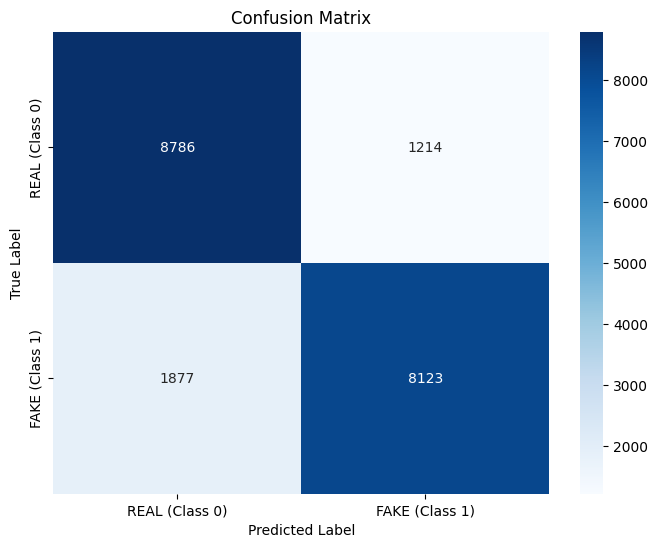


ROC CURVE & AUC SCORE


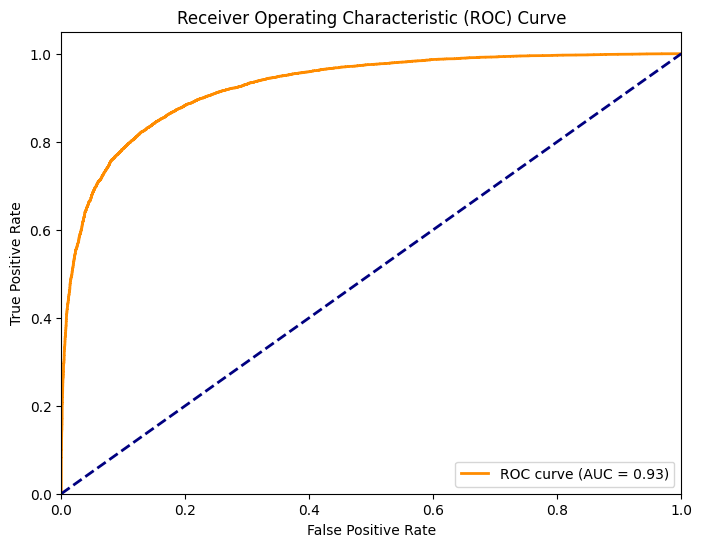


Area Under Curve (AUC): 0.9259


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tqdm.notebook import tqdm

# --- 1. Load the Best Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

try:
    model.load_state_dict(torch.load("best_cifake_model.pth"))
    print("Successfully loaded 'best_cifake_model.pth'")
except FileNotFoundError:
    print("Error: 'best_cifake_model.pth' not found. Please ensure the model was trained and saved.")

model.eval() # Set the model to evaluation mode

# --- 2. Get All Predictions from the Test Set ---
all_labels = []
all_preds = []
all_probs = []

print("Running evaluation on the entire test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels']

        outputs = model(inputs)

        # Get probabilities for ROC curve
        probs = torch.sigmoid(outputs).cpu()
        # Get final predictions (0 or 1)
        preds = (probs > 0.5).int()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()

# --- 3. Display Classification Report ---
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
# Define target names for the report
target_names = ['REAL (Class 0)', 'FAKE (Class 1)']
print(classification_report(all_labels, all_preds, target_names=target_names))

# --- 4. Display Confusion Matrix ---
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 5. Display ROC Curve and AUC Score ---
print("\n" + "="*50)
print("ROC CURVE & AUC SCORE")
print("="*50)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nArea Under Curve (AUC): {auc_score:.4f}")

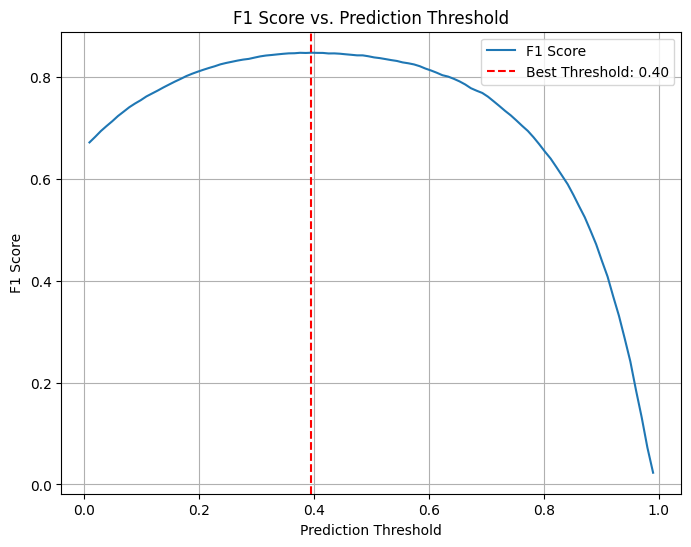

Optimal threshold to maximize F1-score is: 0.3961
Best F1-score at this threshold: 0.8479


In [ ]:
from sklearn.metrics import f1_score as sk_f1_score

# Test thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [sk_f1_score(all_labels, all_probs > t) for t in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Plot the F1 score vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Prediction Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Prediction Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal threshold to maximize F1-score is: {best_threshold:.4f}")
print(f"Best F1-score at this threshold: {best_f1:.4f}")

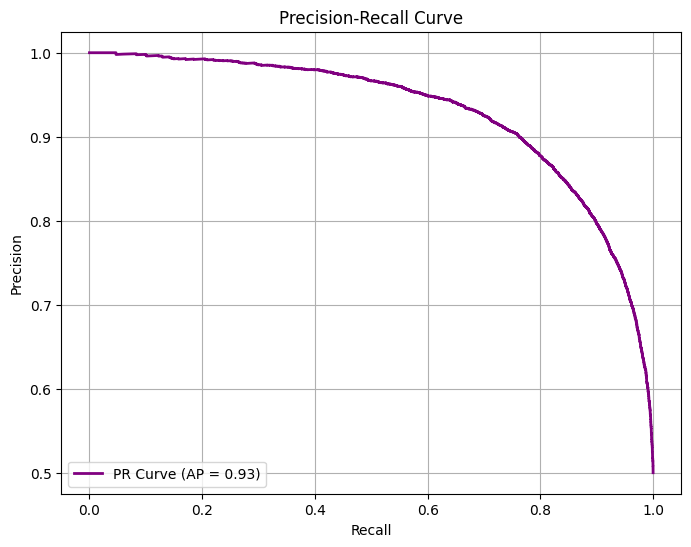


Average Precision (AP) Score: 0.9290


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"\nAverage Precision (AP) Score: {ap_score:.4f}")